# Differentially Expressed Genes


1) Compute co-expression network using FC values;


2) Compare hubs sets related to the use of different centrality measures;


3) Only considering degree index, are the hubs up or down regulated?;




## Data preparation


For 58 patients, we have gene expressions data for both the conditions: Tumoral and Normal.

Then we clean our dasates in order to make them ready to next analysis.

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
from pylab import rcParams
rcParams['figure.figsize'] = 20, 20
import warnings
import matplotlib.pyplot as plt
import os

In [2]:
normal = pd.read_excel("THCA_GeneExpressionData.xlsx", 'Normal', header=None)
cancer = pd.read_excel("THCA_GeneExpressionData.xlsx", 'Cancer',header= None)

In [3]:
normal.head()

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,'TFF3','ENSG00000160180',622.607119,911.238191,782.815950,723.797781,496.404954,374.668183,1367.935443,615.456310,...,896.418521,299.535965,276.921670,583.246286,583.064930,214.829665,1055.960917,761.631761,882.446493,455.488719
1,'CCL21','ENSG00000137077',141.143778,308.139249,102.010917,85.484540,174.184587,22.815833,1269.861572,249.747474,...,137.181259,182.893781,343.919930,192.194950,178.492568,2106.870328,176.595873,401.788691,326.611171,343.397626
2,'TPO','ENSG00000115705',698.768518,1056.633870,696.999593,588.426332,317.899894,765.186938,476.263234,574.988028,...,1145.690498,675.493985,689.568364,345.221878,569.726570,177.989249,625.257920,341.558891,648.757829,736.420442
3,'DPT','ENSG00000143196',43.504133,43.547923,24.063850,33.640337,40.965381,11.336433,100.549599,75.498403,...,40.370660,142.990041,47.737490,91.465032,76.454666,99.881000,29.448615,78.103291,45.823164,82.541244
4,'MT1G','ENSG00000125144',705.710272,819.178138,1533.015722,653.077437,801.255883,1421.052819,735.072640,284.092957,...,570.660189,671.152427,802.252596,119.426604,786.278526,68.487979,167.183935,398.233866,555.446939,162.142400


In [4]:
cancer.head()


,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,'TFF3','ENSG00000160180',4.242525,2.408425,4.937478,1.960715,155.800889,10.384830,31.700384,4.119579,...,1.999227,2.052689,10.559928,8.525359,49.263282,54.403689,9.803273,11.030324,4.809581,264.649022
1,'CCL21','ENSG00000137077',2.410811,1.089017,1.017587,1.910808,40.751680,1.036390,3.321811,1.781459,...,1.172240,5.300172,42.487365,5.227811,1.296241,105.487968,3.139990,2.125833,1.094423,1.035321
2,'TPO','ENSG00000115705',10.190786,4.995773,32.883959,1.748823,413.861706,11.899227,405.664299,10.169871,...,1.482730,8.582763,72.281744,2.238447,276.736334,189.175525,6.642643,90.355691,11.683205,179.136533
3,'DPT','ENSG00000143196',3.120532,1.460538,1.045495,1.525846,11.234633,1.018827,1.040857,1.721509,...,1.698025,7.529241,2.985804,11.198233,1.513879,28.833146,1.962730,1.429909,1.122126,1.054821
4,'MT1G','ENSG00000125144',7.495076,12.844289,5.875238,3.049080,4355.860153,1.268993,366.887333,3.621664,...,1.707332,9.938978,9.371669,2.823032,2901.081725,20.471450,45.200947,119.987037,24.731153,5308.810777


In [5]:
# saving labels genes in a list
labels = list(cancer[cancer.columns[0]])
# dropping first 2 cols in both datasets
cancer.drop(0, axis = 1, inplace= True)
cancer.drop(1, axis=1, inplace = True)
normal.drop(0, axis = 1, inplace= True)
normal.drop(1, axis=1, inplace = True)

## Co-Expression network using Fold-Change values

Fold Change is useful to identify genes whose expression in the two
groups of considered samples varies by a certain proportion (doubles,
halves, ...).

We define FC as follows:

$$FC = log_2 (\frac{Tumoral Expr}{Normal Expr})$$


Choosing a certain FC threshold, all the genes with absolute value of FC higher than the threshold will be differentially expressed, then they will change significantly passing from a normal condition to a tumoral one.


After this, based on the FC matrix, we compute the correlation matrix and, choosing a certain threshold, we will build an adjacency matrix: higher values will correspond to ones in our adjacency matrix, lower ones will be zeros.

So, we can obtain our directed graph.


In [6]:
# FC
fold_change = cancer.div(normal).apply(np.log2)
fold_change.head()

,2,3,4,5,6,7,8,9,10,11,...,50,51,52,53,54,55,56,57,58,59
0,-7.197255,-8.563595,-7.308755,-8.528063,-1.671814,-5.173064,-5.431356,-7.223016,3.459075,-5.054449,...,-8.808586,-7.189070,-4.712806,-6.096201,-3.565072,-1.981417,-6.751077,-6.109547,-7.519454,-0.783335
1,-5.871503,-8.144412,-6.647427,-5.483409,-2.095686,-4.460397,-8.578486,-7.131267,10.474062,-2.866054,...,-6.870672,-5.108823,-3.016967,-5.200220,-7.105387,-4.319951,-5.813548,-7.562265,-8.221260,-8.373658
2,-6.099477,-7.724552,-4.405702,-8.394334,0.380576,-6.006872,-0.231473,-5.821159,-1.031682,-3.963968,...,-9.593746,-6.298357,-3.253990,-7.268882,-1.041758,0.087935,-6.556550,-1.918447,-5.795172,-2.039470
3,-3.801289,-4.898033,-4.524609,-4.462511,-1.866452,-3.475986,-6.593991,-5.454701,4.902794,-2.054765,...,-4.571378,-4.247266,-3.998931,-3.029949,-5.658283,-1.792482,-3.907266,-5.771388,-5.351770,-6.290046
4,-6.556989,-5.994978,-8.027509,-7.742736,2.442623,-10.129060,-1.002550,-6.293567,-3.082997,-3.697619,...,-8.384745,-6.077399,-6.419607,-5.402735,1.883479,-1.742238,-1.887011,-1.730737,-4.489248,5.033055


In [7]:
corr_matrix = pd.DataFrame.transpose(fold_change).corr()
corr_matrix.head()

,0,1,2,3,4,5,6,7,8,9,...,384,385,386,387,388,389,390,391,392,393
0,1.000000,0.533793,0.772992,0.492826,0.635073,0.838388,0.732291,0.716515,0.656800,0.654825,...,-0.578051,-0.571108,-0.455523,-0.597850,-0.584562,-0.559537,-0.470610,-0.626450,-0.558224,-0.272174
1,0.533793,1.000000,0.246656,0.873809,0.037931,0.509596,0.365503,0.070826,0.192605,0.263826,...,-0.112838,-0.327747,-0.262581,-0.067010,-0.057984,-0.366726,-0.194401,-0.041020,-0.130481,-0.112568
2,0.772992,0.246656,1.000000,0.178604,0.750580,0.665873,0.581384,0.753734,0.806815,0.750635,...,-0.773363,-0.391865,-0.452203,-0.735169,-0.756006,-0.536444,-0.581118,-0.723394,-0.627648,-0.347041
3,0.492826,0.873809,0.178604,1.000000,0.031102,0.512418,0.368697,0.009488,0.194976,0.193357,...,-0.040136,-0.285741,-0.173377,0.039975,0.009947,-0.276208,-0.176373,0.035805,0.004234,-0.096084
4,0.635073,0.037931,0.750580,0.031102,1.000000,0.480172,0.496924,0.834981,0.659998,0.596825,...,-0.706606,-0.386596,-0.361733,-0.717194,-0.727776,-0.478046,-0.626299,-0.713454,-0.526670,-0.413803


In [8]:
th = 0.6
adj_matrix = np.where(np.abs(corr_matrix)>=th, 1,0)
#adj_matrix.shape

In [9]:
graph = nx.from_numpy_matrix(adj_matrix, create_using=nx.DiGraph)

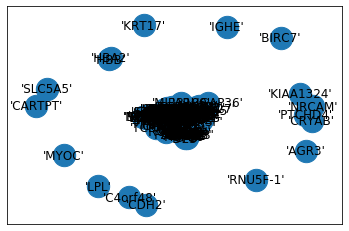

In [10]:
warnings.filterwarnings("ignore", category=UserWarning)
nx.draw_networkx(graph, node_size = 500, labels = dict(zip([x for x in range(len(labels))], labels)))
plt.show()

## Centrality measures

Let's compute the betweenness centrality measure on our graph, saving results on a txt file.

Betweenness centrality is a measure of centrality in a graph based on shortest paths. For every pair of vertices in a connected graph, there exists at least one shortest path between the vertices such that either the number of edges that the path passes through (for unweighted graphs) or the sum of the weights of the edges (for weighted graphs) is minimized. The betweenness centrality for each vertex is the number of these shortest paths that pass through the vertex.

In [11]:
btw_dic = dict(nx.betweenness_centrality(graph))
try:
    os.remove('betweenness_centrality.txt')
    with open('betweenness_centrality.txt', 'w') as f:
        print(btw_dic, file=f)
except:
    with open('betweenness_centrality.txt', 'w') as f:
        print(btw_dic, file=f)

## Up & Down Regulated Hubs

At first let's find our hubs, or in other words the first $5\%$ of genes in our graph with the higest value od degree.

Then, for these hubs, we can check their regulation (up or down regulation).

In [13]:
mean_col = fold_change.mean(axis= 1)
mean_col = np.asarray(mean_col)
fold_change["Mean"] = mean_col
fold_change.head()

,2,3,4,5,6,7,8,9,10,11,...,51,52,53,54,55,56,57,58,59,Mean
0,-7.197255,-8.563595,-7.308755,-8.528063,-1.671814,-5.173064,-5.431356,-7.223016,3.459075,-5.054449,...,-7.189070,-4.712806,-6.096201,-3.565072,-1.981417,-6.751077,-6.109547,-7.519454,-0.783335,-5.746879
1,-5.871503,-8.144412,-6.647427,-5.483409,-2.095686,-4.460397,-8.578486,-7.131267,10.474062,-2.866054,...,-5.108823,-3.016967,-5.200220,-7.105387,-4.319951,-5.813548,-7.562265,-8.221260,-8.373658,-5.220564
2,-6.099477,-7.724552,-4.405702,-8.394334,0.380576,-6.006872,-0.231473,-5.821159,-1.031682,-3.963968,...,-6.298357,-3.253990,-7.268882,-1.041758,0.087935,-6.556550,-1.918447,-5.795172,-2.039470,-4.431890
3,-3.801289,-4.898033,-4.524609,-4.462511,-1.866452,-3.475986,-6.593991,-5.454701,4.902794,-2.054765,...,-4.247266,-3.998931,-3.029949,-5.658283,-1.792482,-3.907266,-5.771388,-5.351770,-6.290046,-3.989061
4,-6.556989,-5.994978,-8.027509,-7.742736,2.442623,-10.129060,-1.002550,-6.293567,-3.082997,-3.697619,...,-6.077399,-6.419607,-5.402735,1.883479,-1.742238,-1.887011,-1.730737,-4.489248,5.033055,-3.863003


In [14]:
# selecting hubs (first 5% of nodes with the higest degree)
degree = list(graph.degree)
degree.sort(key=lambda x: x[1], reverse=True)
top_5 = degree[:round(len(degree)*0.05)]
top_5

[(37, 410),
 (134, 384),
 (342, 374),
 (377, 372),
 (32, 370),
 (63, 370),
 (357, 370),
 (388, 366),
 (62, 358),
 (371, 356),
 (72, 354),
 (57, 346),
 (281, 346),
 (341, 346),
 (65, 342),
 (142, 338),
 (359, 334),
 (132, 332),
 (318, 332),
 (340, 330)]

In [15]:
# adding labels to FC df
fold_change.set_index([labels], inplace=True)
fold_change.head()

,2,3,4,5,6,7,8,9,10,11,...,51,52,53,54,55,56,57,58,59,Mean
'TFF3',-7.197255,-8.563595,-7.308755,-8.528063,-1.671814,-5.173064,-5.431356,-7.223016,3.459075,-5.054449,...,-7.189070,-4.712806,-6.096201,-3.565072,-1.981417,-6.751077,-6.109547,-7.519454,-0.783335,-5.746879
'CCL21',-5.871503,-8.144412,-6.647427,-5.483409,-2.095686,-4.460397,-8.578486,-7.131267,10.474062,-2.866054,...,-5.108823,-3.016967,-5.200220,-7.105387,-4.319951,-5.813548,-7.562265,-8.221260,-8.373658,-5.220564
'TPO',-6.099477,-7.724552,-4.405702,-8.394334,0.380576,-6.006872,-0.231473,-5.821159,-1.031682,-3.963968,...,-6.298357,-3.253990,-7.268882,-1.041758,0.087935,-6.556550,-1.918447,-5.795172,-2.039470,-4.431890
'DPT',-3.801289,-4.898033,-4.524609,-4.462511,-1.866452,-3.475986,-6.593991,-5.454701,4.902794,-2.054765,...,-4.247266,-3.998931,-3.029949,-5.658283,-1.792482,-3.907266,-5.771388,-5.351770,-6.290046,-3.989061
'MT1G',-6.556989,-5.994978,-8.027509,-7.742736,2.442623,-10.129060,-1.002550,-6.293567,-3.082997,-3.697619,...,-6.077399,-6.419607,-5.402735,1.883479,-1.742238,-1.887011,-1.730737,-4.489248,5.033055,-3.863003


In [16]:
up = []
down = []
for i in top_5:
    gene_idx = i[0]
    if fold_change.iloc[gene_idx].Mean >=0:
        up.append((labels[gene_idx],fold_change.iloc[gene_idx].Mean))
    else:
        down.append((labels[gene_idx],fold_change.iloc[gene_idx].Mean))

In [17]:
# up-regulated genes
up


[("'NECTIN4'", 2.4352486840167002),
 ("'LIPH'", 3.2829113007788284),
 ("'NGEF'", 2.6612684267993765),
 ("'SERPINA1'", 3.7489453588104156),
 ("'LAMB3'", 3.0957170260949676),
 ("'LAD1'", 1.853712387783724),
 ("'GALE'", 2.4124575972554347),
 ("'PDLIM4'", 2.680300866035602),
 ("'LGALS3'", 2.1770570483253873),
 ("'KCNN4'", 2.369034954790098)]

In [18]:
# down-regulated genes
down

[("'SLC4A4'", -2.5304434240682685),
 ("'MRO'", -1.7075101954635463),
 ("'HGD'", -2.6190977038816654),
 ("'MPPED2'", -2.162164929590883),
 ("'SORBS2'", -2.181785707680331),
 ("'SPX'", -2.085581156739021),
 ("'ZMAT4'", -2.2090238558180895),
 ("'ITPR1'", -2.141610600845395),
 ("'CDON'", -1.6818727432385652),
 ("'?'", -1.713732290151986)]